In [1]:
%matplotlib inline

# Input Datasets  

In [2]:
import pandas
data_folder = '../data'
date_format='%Y-%M-%d' #truncate datetimes to dates
invoices = pandas.read_csv(data_folder + '/invoice.csv', na_values='inf', 
                           parse_dates=['invoice_date', 'due_date', 'cleared_date'], date_format=date_format)
payments = pandas.read_csv(data_folder + '/invoice_payments.csv', na_values='inf',
                           parse_dates=['transaction_date'], date_format=date_format)

## Dataset Definitions & Relationships

We have two input datasets: invoices and their payments.
- Payments are amounts in time, which are directly mapped to companies. 
- Invoices can have multiple payments, but usually only have 1. 

In [3]:
invoices.dtypes

id                                   int64
due_date                    datetime64[ns]
invoice_date                datetime64[ns]
status                              object
amount_inv                         float64
currency                            object
company_id                           int64
customer_id                          int64
account_id                           int64
cleared_date                datetime64[ns]
root_exchange_rate_value           float64
dtype: object

In [4]:
payments.dtypes

amount                             float64
root_exchange_rate_value           float64
transaction_date            datetime64[ns]
invoice_id                           int64
company_id                           int64
converted_amount                   float64
dtype: object

In [5]:
#The join key will be invoice_id, so it must be unique (and it is).
invoices.id.value_counts(dropna=False).value_counts(dropna=False)\
.to_frame(name="ids").rename_axis('invoices_per_id')

,ids
invoices_per_id,
1,113085


In [6]:
#all payments are represented in both datasets 
len(set(payments.invoice_id) - set(invoices.id))

0

In [7]:
#7% of invoices do not have payments yet
len(set(invoices.id) - set(payments.invoice_id))/invoices.__len__()

0.07127382057744175

In [8]:
#invoices usually have one payment but may have more
payments.invoice_id.value_counts(dropna=False).value_counts(dropna=False, normalize=True)\
.to_frame(name="invoices").rename_axis('payments_per_invoice')

,invoices
payments_per_invoice,
1,0.941871
2,0.054758
3,0.002552
4,0.000562
5,0.000143
6,0.000076
14,0.000010
9,0.000010
8,0.000010


## Entity Definitions & Relationships

- Company: business entity for which Tesorio is forecasting cash collected. There are only two. Each company collects using multiple currencies from multiple customers. 
- Account: **In this limited dataset, accounts and companies are synonymous, so we ignore accounts.**  
- Customer: metadata about an invoice which is specific to each company. 

In [9]:
invoices.groupby("company_id")[["customer_id","currency"]].nunique()

,customer_id,currency
company_id,,
14,546,13
114,4509,15


In [10]:
invoices.groupby("customer_id").company_id.nunique().value_counts()\
.to_frame(name='customers').rename_axis('companies_per_customer')

,customers
companies_per_customer,
1,5055


In [11]:
invoices.groupby("company_id").account_id.nunique().to_frame(name="unique_accounts")

,unique_accounts
company_id,
14,1
114,1


In [12]:
invoices.groupby("account_id").company_id.nunique().value_counts()\
.to_frame(name='count').rename_axis('companies_per_account')

,count
companies_per_account,
1,2


## Data Cleaning Needs

### Payments

Transaction data begins in 2011 and ends on 2021-01-31. We will assume this is when the data was pulled. 

In [13]:
payments.__len__()

111623

In [14]:
payment_stats = payments.describe(exclude='int')
payment_stats.loc['% populated'] = payment_stats.loc['count']/payments.__len__()
payment_stats

,amount,root_exchange_rate_value,transaction_date,converted_amount
count,111622.000000,111623.000000,111623,1.116220e+05
mean,9416.980646,0.968372,2017-09-21 16:48:01.513129216,9.128716e+03
min,0.000004,0.000806,2011-01-01 00:05:00,1.800562e-08
25%,4078.626249,1.000000,2016-01-18 00:07:00,3.180972e+03
50%,9332.665539,1.000000,2018-01-20 00:02:00,8.819620e+03
75%,14651.495863,1.000000,2020-01-05 00:02:00,1.461286e+04
max,19999.879159,3.253307,2021-01-31 00:03:00,6.120943e+04
std,6015.336178,0.244600,NaN,6.438813e+03
% populated,0.999991,1.000000,1.0,9.999910e-01


In [15]:
last_transaction_date = payments.transaction_date.max()
first_transaction_date = payments.transaction_date.min()
first_transaction_date, last_transaction_date

(Timestamp('2011-01-01 00:05:00'), Timestamp('2021-01-31 00:03:00'))

In [16]:
#converted_amount is reliable
(((payments.amount * payments.root_exchange_rate_value) - payments.converted_amount).abs()).max()

1.0913936421275139e-11

In [17]:
payments[payments.amount.isnull()!=payments.converted_amount.isnull()].__len__()

0

array([[<Axes: title={'center': 'amount'}>,
        <Axes: title={'center': 'root_exchange_rate_value'}>,
        <Axes: title={'center': 'converted_amount'}>]], dtype=object)

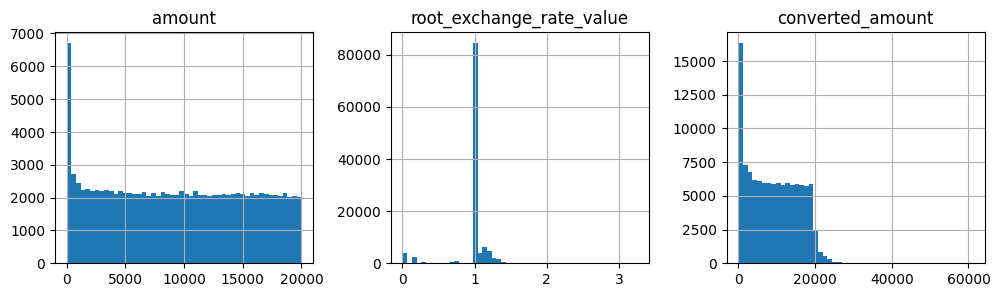

In [18]:
payments.select_dtypes(include='float').hist(bins=50, figsize=(12, 3), layout=(1,3))

### Invoices

In [19]:
#opened outside of payment data time period or after they were due - need to filter 
(invoices.loc[invoices.invoice_date>last_transaction_date].__len__(), 
invoices.loc[invoices.invoice_date<first_transaction_date].__len__(), 
invoices.loc[invoices.invoice_date.dt.to_period('M')>invoices.due_date.dt.to_period('M')].__len__())

(15, 1, 8)

In [21]:
invoices = invoices.loc[(invoices.invoice_date>=first_transaction_date) &
                        (invoices.invoice_date<=last_transaction_date) & 
                        (invoices.invoice_date.dt.to_period('M')<=invoices.due_date.dt.to_period('M'))]

In [22]:
#to compare to payments. Are we holding the customer accountable to USD or their own currency?
invoices['converted_amount'] = invoices.amount_inv * invoices.root_exchange_rate_value

In [23]:
invoices_stats = invoices.describe(exclude='int')
invoices_stats.loc['% populated'] = invoices_stats.loc['count']/invoices.__len__()
invoices_stats

,due_date,invoice_date,status,amount_inv,currency,cleared_date,root_exchange_rate_value,converted_amount
count,113036,113036,113036,113036.000000,113036,113036,113036.000000,113036.000000
unique,NaN,NaN,2,NaN,18,NaN,NaN,NaN
top,NaN,NaN,CLEARED,NaN,USD,NaN,NaN,NaN
freq,NaN,NaN,109348,NaN,85108,NaN,NaN,NaN
mean,2017-10-17 22:28:07.196645632,2017-09-09 17:55:30.649704448,NaN,10026.752277,NaN,2017-11-17 22:46:37.326692352,0.970802,9742.174421
min,2011-01-01 00:05:00,2011-01-01 00:05:00,NaN,0.027581,NaN,2011-01-01 00:05:00,0.000815,0.007976
25%,2016-01-20 00:05:00,2016-01-18 00:08:00,NaN,5030.646720,NaN,2016-01-21 00:08:00,1.000000,4161.228596
50%,2018-01-22 00:04:00,2018-01-20 00:05:00,NaN,10017.743195,NaN,2018-01-24 00:04:00,1.000000,9587.389379
75%,2020-01-11 00:07:00,2020-01-08 00:11:00,NaN,15030.595146,NaN,2020-01-10 00:05:00,1.000000,15058.319044
max,2022-01-15 00:01:00,2021-01-31 00:03:00,NaN,19999.974875,NaN,2022-01-01 00:01:00,1.681560,32285.475685


In [24]:
invoices['months_allowed'] = invoices.due_date.dt.to_period('M') - invoices.invoice_date.dt.to_period('M')
invoices.months_allowed = invoices.months_allowed.map(lambda m: m.n if not pandas.isnull(m) else None)
#almost all invoices are due immediately or in 1 year. should filter out the rest
invoices.months_allowed.value_counts(normalize=True, dropna=False)

months_allowed
0     0.893556
12    0.106426
24    0.000018
Name: proportion, dtype: float64

### Exchange Rate

Exchange rates vary for both payments and open invoices. Customers would expect to pay the amount they were originally invoiced in their own currency, not the USD amount originally invoiced. Therefore, we should use raw amounts to determine how much is paid vs due. 

<Axes: title={'center': 'Exchange Rate Spread Ratio'}, xlabel='currency'>

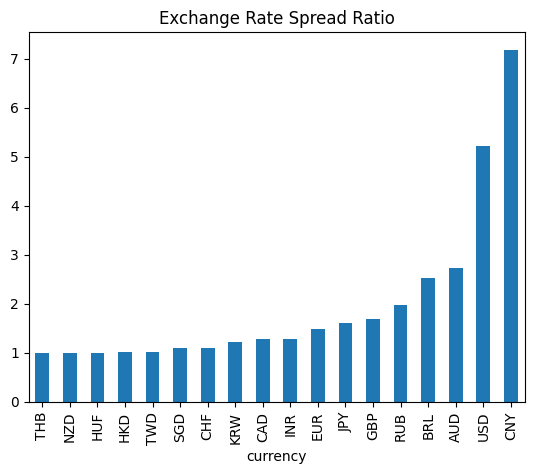

In [25]:
# USD is not is always 1 - it varies a lot
currency_ranges = invoices.groupby("currency").root_exchange_rate_value.describe(percentiles=[])
(currency_ranges['max']/currency_ranges['min']).sort_values().plot(kind='bar', title="Exchange Rate Spread Ratio")

In [26]:
# 1.6% of USD invoices have an exchange rate unequal to 1
invoices_usd = invoices.query("currency=='USD'").copy()
invoices_usd['exchange_rate_is_1'] = invoices_usd['root_exchange_rate_value'] == 1
1 - invoices_usd.exchange_rate_is_1.mean()

0.015756450627438023

In [27]:
# USD exchange rate variations from 1 tend to be invoices which took longer to clear
# This suggests that the invoice exchange rate is "current state data." 
time_to_clear = invoices_usd.cleared_date - invoices_usd.invoice_date
invoices_usd['months_to_clear'] = time_to_clear.map(lambda t: round(t.days/30))

In [28]:
invoices_usd.groupby("exchange_rate_is_1").months_to_clear.agg(['mean','count'])

,mean,count
exchange_rate_is_1,,
False,3.553318,1341
True,2.104444,83767


<Axes: title={'center': '% of USD Invoices With Exchange Rate Equal to 1'}, xlabel='months_to_clear'>

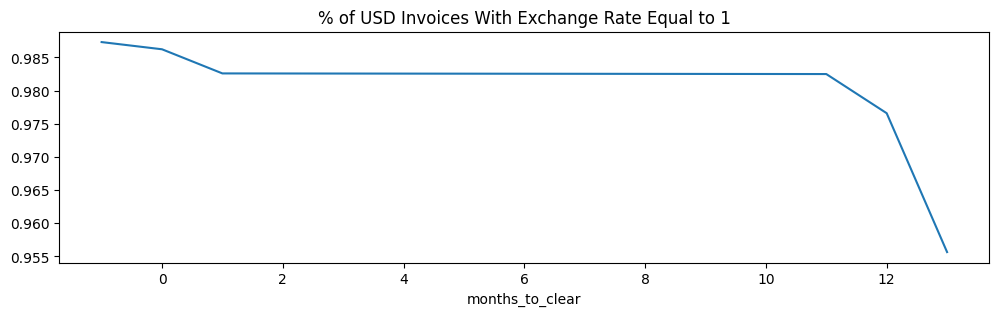

In [29]:
invoices_usd.groupby(invoices_usd.months_to_clear.clip(upper=13, lower=-1))\
.exchange_rate_is_1.mean().plot(title='% of USD Invoices With Exchange Rate Equal to 1', figsize=(12,3))

### Invoice status vs cleared date

All invoices have a date cleared. 
When an invoice is open, the date cleared is set to the future, and seems to be an assumed value. 

In [30]:
invoices.loc[invoices.cleared_date.isnull()].__len__()

0

In [31]:
invoices.status.value_counts(normalize=True, dropna=False).to_frame(name="% of Invoices")

,% of Invoices
status,
CLEARED,0.967373
OPEN,0.032627


In [32]:
invoices.loc[invoices.cleared_date.isnull() != (invoices.status == 'OPEN'),['status','cleared_date']]\
.value_counts(dropna=False)

status  cleared_date       
OPEN    2022-01-01 00:01:00    3688
Name: count, dtype: int64

In [33]:
#all open invoices have the same cleared date, which is in the future relative to the latest transaction
invoices.loc[invoices.status == 'OPEN'].cleared_date.value_counts(dropna=False)

cleared_date
2022-01-01 00:01:00    3688
Name: count, dtype: int64

In [34]:
#all cleared invoices have a cleared date before or on the date of the latest transaction
invoices.loc[invoices.status == 'CLEARED', 'cleared_date'].max()

Timestamp('2021-01-31 00:03:00')

In [35]:
#some open invoices are already active, whereas some become active in the future
invoices.loc[invoices.status == 'OPEN', ['invoice_date','due_date']].agg(['max','min'])

,invoice_date,due_date
max,2021-01-31 00:03:00,2022-01-15 00:01:00
min,2019-01-03 00:09:00,2019-01-03 00:10:00


### Merging & Checking for Consistency

- Invoices must become active within the date range of the transactions data to ensure completeness.
- No individual payments are more than their invoices. 
- Exchange rates vary across payments.
- Companies are consistent between payments and invoices, when payments are present. 
- Amounts make the most sense in their original currencies vs in USD

In [36]:
invoice_payments = invoices.rename(columns={"id":"invoice_id","amount_inv":"amount"})\
.merge(payments, on="invoice_id", how='left', suffixes=('_inv', '_pmt'))

In [37]:
invoice_payments.invoice_id.nunique()

113036

In [38]:
duplicated_columns = [col.replace('_pmt','') for col in invoice_payments.columns if col.endswith('_pmt')]
for col in  duplicated_columns:
    inconsistent_rows = invoice_payments.loc[invoice_payments[col + '_pmt']!=invoice_payments[col + '_inv']]
    print(f"{col}: {inconsistent_rows.__len__()/invoice_payments.__len__()} inconsistent rows in merged dataset")

amount: 0.18279318214115542 inconsistent rows in merged dataset
root_exchange_rate_value: 0.30674513278774856 inconsistent rows in merged dataset
company_id: 0.06722562632181699 inconsistent rows in merged dataset
converted_amount: 0.38665184281140547 inconsistent rows in merged dataset


In [39]:
invoice_payments.query("company_id_pmt!=company_id_inv").company_id_pmt.value_counts(dropna=False)

company_id_pmt
NaN    8042
Name: count, dtype: int64

In [40]:
invoice_payments.query("amount_pmt!=amount_inv")[['amount_pmt','amount_inv']].describe()

,amount_pmt,amount_inv
count,13824.000000,21867.000000
mean,5019.564845,9966.640444
std,5890.300951,5768.272356
min,0.000004,2.210771
25%,94.819108,4955.695498
50%,2088.978587,9941.009610
75%,9185.545594,14935.048061
max,19989.986608,19999.974875


In [41]:
#no payment is more than the invoice amount in the original currency
invoice_payments.loc[invoice_payments.amount_pmt>invoice_payments.amount_inv].__len__()

0

In [42]:
#converting to USD creates payments that are higher than invoice totals
invoice_payments.loc[invoice_payments.converted_amount_pmt>invoice_payments.converted_amount_inv].__len__()

11072

### Business Questions for the Data

In [43]:
invoice_payments['amount_pmt_pct'] = (invoice_payments.amount_pmt/invoice_payments.amount_inv).round(2)

In [44]:
# Rougly 10% of payments are partial
(invoice_payments.amount_pmt_pct.dropna()<1).mean()

0.10207556638944651

<Axes: title={'center': '% of Invoice Collected with Payment'}, ylabel='Frequency'>

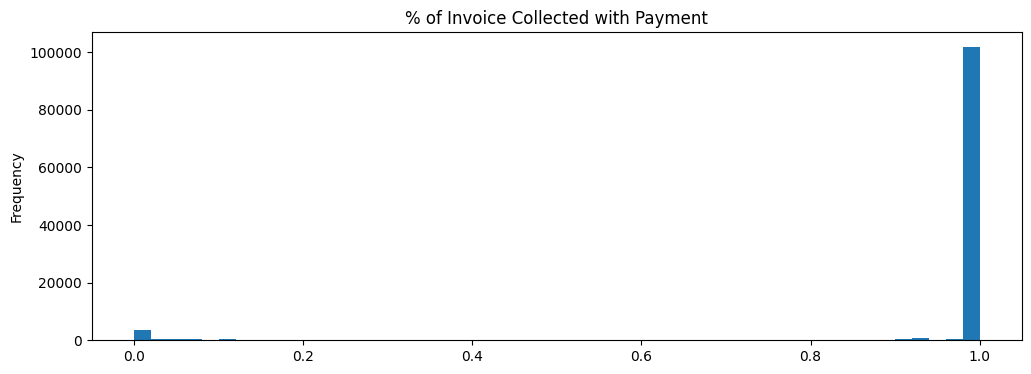

In [45]:
invoice_payments.amount_pmt_pct\
.plot(kind="hist",bins=50, title="% of Invoice Collected with Payment", figsize=(12,4))

In [46]:
invoice_payments.sort_values(by=['invoice_id','transaction_date'], inplace=True)
invoice_payments['pct_invoice_collected'] = invoice_payments.groupby("invoice_id").amount_pmt_pct.cumsum()

In [47]:
# negligible % of payments are overpayments - filter out
(invoice_payments.pct_invoice_collected>1).mean()

0.0008108537370326097

In [196]:
invoice_payments_rollup = invoice_payments.query("pct_invoice_collected<=1")\
.groupby("invoice_id", as_index=False)\
.agg({"amount_pmt":['sum','count'],"transaction_date":['min','max'],"pct_invoice_collected":"max"})
invoice_payments_rollup.columns = invoice_payments_rollup.columns.to_flat_index().map('_'.join)
payment_totals = invoices.merge(invoice_payments_rollup, how="left", left_on="id", right_on="invoice_id_")
payment_totals.pct_invoice_collected_max = payment_totals.pct_invoice_collected_max.fillna(0)

#### Comparing invoice status and % collected 

- Invoices with cleared status can still have amounts remaining. 
- Invoices with open status are rarely collected. 

In [197]:
# define invoice as collected if total payments meet invoice amount in original currencies. 92% are collected
payment_totals['collected'] = payment_totals.pct_invoice_collected_max==1
payment_totals.collected.mean()

0.9172387557946141

In [198]:
#define cleared based on status. 97% are cleared
payment_totals['cleared'] = payment_totals.status=='CLEARED'
payment_totals.cleared.mean()

0.967373226228812

In [199]:
#5% of invoices have a mismatch between collected and cleared 
(payment_totals.collected!=payment_totals.cleared).mean()

0.05018755086874978

In [200]:
#on average, cleared invoices are 95% collected, compared to <1% of open ones
payment_totals.groupby("status", as_index=False)[['pct_invoice_collected_max','collected']].mean()

,status,pct_invoice_collected_max,collected
0,CLEARED,0.956600,0.948147
1,OPEN,0.006188,0.000813


In [201]:
#60% of invoices that have not been fully collected are cleared nonetheless. these won't be scored. 
payment_totals.groupby("collected", as_index=False).cleared.mean()

,collected,cleared
0,False,0.606093
1,True,0.999971


#### Cleared Invoices

Cleared invoices may or may not be collected. If not collected, cleared invoices tend to be very late, suggesting that invoices must be cleared at some point.

In [202]:
cleared_invoices = payment_totals.query("cleared == True").copy()
cleared_invoices['months_late'] = \
(cleared_invoices.transaction_date_max.fillna(last_transaction_date).dt.to_period('M')\
- cleared_invoices.due_date.dt.to_period('M')).map(lambda m: m.n if not pandas.isnull(m) else None)

In [203]:
cleared_invoices.groupby("collected")[['months_allowed','months_late']].agg(['mean','min','max'])


months_allowed         months_late         
                    mean min max        mean min  max
collected                                            
False           1.612698   0  24   33.502646 -24  120
True            1.299562   0  24    0.585312 -36   24

#### Comparing date cleared to date collected

There can be a delay between the date an invoice is collected to when it is cleared. We will only forecast invoices when they are open AND not collected. 

In [204]:
payment_totals['collected_date'] = pandas.NaT
payment_totals.loc[payment_totals.collected==1,'collected_date'] = \
payment_totals.loc[payment_totals.collected==1,'transaction_date_max']
payment_totals['clear_delay_months'] = (payment_totals.cleared_date.dt.to_period('M') \
- payment_totals.collected_date.dt.to_period('M')).map(lambda m: m.n if not pandas.isnull(m) else None)

In [221]:
payment_totals.__len__()

113036

In [205]:
payment_totals.clear_delay_months.describe(percentiles=[0.01,0.99])

count    103681.000000
mean          0.124883
std           1.404245
min           0.000000
1%            0.000000
50%           0.000000
99%           0.000000
max          36.000000
Name: clear_delay_months, dtype: float64

# Structuring Data for Business Problem

- The model will handle OPEN invoices and classify how many months in the future they will be collected. 
- Define an invoice as open between its invoice date and date cleared or collected, whichever is first. 

## Creating transaction periods to model historical invoices

To model the data, we have to look the invoices in each prior period they were open and calculate when they are collected relative to that time. The periods we use for modeling must fall within the date range of the transactions data to ensure completeness.

In [208]:
import numpy

def forecast_periods(invoice_date, last_billing_date):
    period_start = max(invoice_date,first_transaction_date.to_period('M'))
    period_end = min(last_billing_date,last_transaction_date.to_period('M'))
    return pandas.period_range(period_start, period_end)

payment_totals['last_forecast_date'] = payment_totals[['cleared_date','collected_date']].min(axis=1)
payment_totals['forecast_month'] = numpy.vectorize(forecast_periods)\
(payment_totals.invoice_date.dt.to_period('M'), payment_totals.last_forecast_date.dt.to_period('M'))
invoice_forecast_periods = payment_totals.explode('forecast_month').dropna(subset=['forecast_month'])
invoice_forecast_periods.forecast_month.agg(['min','max'])

min    2011-01
max    2021-01
Name: forecast_month, dtype: period[M]

In [262]:
invoice_forecast_periods['imputed_collection_date'] = \
invoice_forecast_periods.collected_date.fillna()

Index(['id', 'due_date', 'invoice_date', 'status', 'amount_inv', 'currency',
       'company_id', 'customer_id', 'account_id', 'cleared_date',
       'root_exchange_rate_value', 'converted_amount', 'months_allowed',
       'invoice_id_', 'amount_pmt_sum', 'amount_pmt_count',
       'transaction_date_min', 'transaction_date_max',
       'pct_invoice_collected_max', 'collected', 'cleared', 'collected_date',
       'clear_delay_months', 'last_forecast_date', 'forecast_month'],
      dtype='object')

## Live test cases: current open invoices

Invoices that we will predict after creating the model, without knowing the accuracy of the predictions. 
Per the instructions, we only predict collection dates for open invoices. 

In [210]:
open_invoices = invoices.query("status=='OPEN'").copy()
open_invoices['forecast_month'] = open_invoices.cleared_date.dt.to_period('M')

In [211]:
open_invoices.forecast_month.agg(['min','max'])

min    2022-01
max    2022-01
Name: forecast_month, dtype: period[M]

## Process model inputs

In [286]:
def process_model_inputs(input_df):
    raw_input_columns = ['id','invoice_date', 'months_allowed','amount_inv', 'currency','company_id','customer_id',
                            'forecast_month']
    output_col = 'collected_date'
    if output_col in input_df.columns:
        raw_input_columns += [output_col, 'cleared_date']
    output_df = input_df[raw_input_columns]
    #only forecast when the invoice is active. 
    output_df = output_df[input_df.forecast_month>=output_df.invoice_date.dt.to_period('M')]
    output_df['months_billing'] = (output_df.forecast_month \
                                  - output_df.invoice_date.dt.to_period('M')).map(lambda m: m.n)

    output_df['months_late'] = output_df.months_billing - output_df.months_allowed
    output_df['periods_billing'] = (output_df.months_billing/(output_df.months_allowed+1))
    output_df['periods_late'] = (output_df.months_late/(output_df.months_allowed+1))
    output_df.forecast_month = output_df.forecast_month.dt.to_timestamp()
    return output_df

open_invoices_to_score = process_model_inputs(open_invoices)
invoices_periods_to_model = process_model_inputs(invoice_forecast_periods)

In [287]:
open_invoices_to_score.describe(include='all')

,id,invoice_date,months_allowed,amount_inv,currency,company_id,customer_id,forecast_month,months_billing,months_late,periods_billing,periods_late
count,3688.000000,3688,3688.000000,3688.000000,3688,3688.000000,3688.000000,3688,3688.000000,3688.000000,3688.000000,3688.000000
unique,NaN,NaN,NaN,NaN,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,USD,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,2895,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,57103.281725,2021-01-03 17:26:49.815618048,0.143167,10013.671570,NaN,112.318872,925.635033,2022-01-01 00:00:00.000000256,12.299349,12.156182,12.038044,12.027032
min,12.000000,2019-01-03 00:09:00,0.000000,2.210771,NaN,14.000000,0.000000,2022-01-01 00:00:00,12.000000,0.000000,0.923077,0.000000
25%,29681.500000,2021-01-04 00:03:00,0.000000,5083.409585,NaN,114.000000,138.500000,2022-01-01 00:00:00,12.000000,12.000000,12.000000,12.000000
50%,57827.000000,2021-01-08 00:04:00,0.000000,9928.050159,NaN,114.000000,553.000000,2022-01-01 00:00:00,12.000000,12.000000,12.000000,12.000000
75%,84956.500000,2021-01-22 00:03:00,0.000000,15036.055574,NaN,114.000000,1346.000000,2022-01-01 00:00:00,12.000000,12.000000,12.000000,12.000000
max,113070.000000,2021-01-31 00:03:00,12.000000,19989.653285,NaN,114.000000,5040.000000,2022-01-01 00:00:00,36.000000,36.000000,36.000000,36.000000


## Creating prediction target

Predict months til collected relative to forecast date. Clip outliers to 12 months in the future.  

In [288]:
#true values
invoices_periods_to_model['months_til_collected'] = (invoices_periods_to_model.collected_date.dt.to_period('M') \
                                                - invoices_periods_to_model.forecast_month.dt.to_period('M'))\
.map(lambda m: m.n if not pandas.isnull(m) else None)

In [289]:
invoices_periods_to_model.months_til_collected.kurtosis()

-0.822126175402508

In [290]:
(invoices_periods_to_model.months_til_collected/(invoices_periods_to_model.months_allowed+1)).kurtosis()

3.9232825290341626

In [291]:
# why we clip outliers 
invoices_periods_to_model.months_til_collected.value_counts(normalize=True)

months_til_collected
0.0     0.344955
6.0     0.054314
12.0    0.054314
2.0     0.054314
3.0     0.054314
4.0     0.054314
5.0     0.054314
1.0     0.054314
7.0     0.054314
9.0     0.054314
10.0    0.054314
11.0    0.054314
8.0     0.054314
18.0    0.000273
14.0    0.000273
15.0    0.000273
16.0    0.000273
17.0    0.000273
21.0    0.000273
19.0    0.000273
20.0    0.000273
22.0    0.000273
23.0    0.000273
24.0    0.000273
13.0    0.000273
Name: proportion, dtype: float64

In [292]:
invoices_periods_to_model.months_til_collected = invoices_periods_to_model.months_til_collected.clip(upper=12)

#### Handling historical invoices that were never fully collected

- 8% of historical invoices & amounts never reached a collection state within the period. 
- These tend to be more recent ones. 

In [293]:
invoices_to_model = invoices_periods_to_model.sort_values(by=['id','forecast_month'])\
.drop_duplicates(subset="id", keep="last").copy()
invoices_to_model['collected'] = invoices_to_model.collected_date.isnull()==False

In [294]:
1 - invoices_to_model.collected.mean()

0.08242390957729506

In [295]:
invoices_to_model.groupby("collected").amount_inv.sum()/invoices_to_model.amount_inv.sum()

collected
False    0.081345
True     0.918655
Name: amount_inv, dtype: float64

In [296]:
invoices_to_model.groupby("collected").months_billing.agg(['mean','min','max'])

,mean,min,max
collected,,,
False,1.327028,0,36
True,1.898926,0,24


In [297]:
last_transaction_date + pandas.DateOffset(months=1)

Timestamp('2021-02-28 00:03:00')

In [300]:
def get_fake_collected_date(row):
    if not pandas.isnull(row.collected_date):
        return pandas.NaT
    if 

0.0

In [318]:
uncollected_invoices_to_model = \
invoices_periods_to_model.loc[invoices_periods_to_model.months_til_collected.isnull()].copy()
(uncollected_invoices_to_model.cleared_date > uncollected_invoices_to_model.forecast_month).mean()
# uncollected_invoices_to_model['fake_collected_date'] = (uncollected_invoices_to_model.forecast_month \
#                                                    + pandas.DateOffset(months=13))
# (uncollected_invoices_to_model.collected_date,last_transaction_date + pandas.DateOffset(months=1))
#they may have been collected outside of the transactions window

1.0

# Metadata Calculations & Cleaning

Totals, Uniques, Averages, Ranges, Outliers, Missings
Variables: Invoices, USD Amounts, Cleared/Open, Due Date, Invoice Date, Transaction Date, Customers, Companies, Accounts

In [249]:
payments.query("invoice_id==24212")

,amount,root_exchange_rate_value,transaction_date,invoice_id,company_id,converted_amount


# Notes

## Notable entities

e.g. customers with notable values

## Sparsity

### Entities

### Date Periods

## Trends Over Time

# Analysis

## Business Motivation

Cash collections don't follow due dates

## Data Science Benchmark

Define & Quantify: customers' mean absolute % error each period from cash due.

## Data Science Target

Best outcome variable? 
Days late
Days open (Total and Rolling)
Days Open as a % of Payment Window (Total and Rolling)
Days Late as a % of Payment Window (Total and Rolling)